In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image

import pandas as pd

import torch
from torch.utils.data import DataLoader
from preprocessing import *
from experimental_neural_nets import Conv_test, Road_data, UNet
from road_correction import process_roads, f1_loss_numpy

c:\Users\hudrya\anaconda3\lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\hudrya\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\hudrya\anaconda3\lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [2]:
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

In [3]:
root_dir = "data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files))  # Load maximum 100 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

#imgs,gt_imgs = rotate_train_data(imgs,gt_imgs)
#imgs,gt_imgs = flip_train_data(imgs,gt_imgs)

Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


In [4]:
model = UNet(base_c=8,num_layers=5)

down
(8, 16)
(16, 32)
(32, 64)
(64, 128)
(128, 256)
Up
(256, 128)
(128, 64)
(64, 32)
(32, 16)
(16, 8)


In [5]:
num_epochs = 10

dataset = Road_data(imgs,gt_imgs)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(dataloader):

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    scheduler.step()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/10, Loss: 0.8707
Epoch 2/10, Loss: 0.8237
Epoch 3/10, Loss: 0.8435
Epoch 4/10, Loss: 0.8325
Epoch 5/10, Loss: 0.8123
Epoch 6/10, Loss: 0.8211
Epoch 7/10, Loss: 0.7914
Epoch 8/10, Loss: 0.7819
Epoch 9/10, Loss: 0.7807
Epoch 10/10, Loss: 0.7776


batch index : 0
batch index : 1
batch index : 2
batch index : 3
batch index : 4


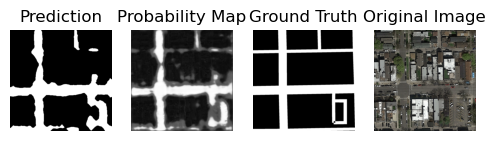

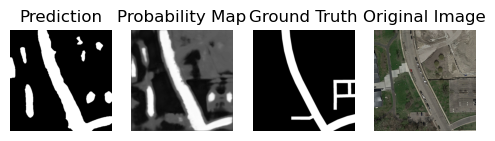

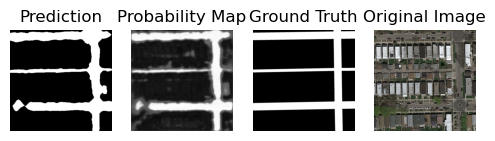

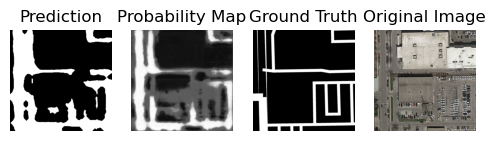

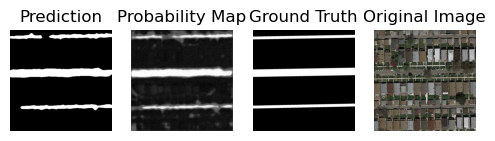

In [6]:
dataset_check = Road_data(imgs, gt_imgs)
dataloader = DataLoader(dataset_check, batch_size=20, shuffle=True)

best_t = 0
best_outlier_size = 0
best_shape_size = 0
best_loss = np.inf

for batch_idx, (data, target) in enumerate(dataloader):
    print(f'batch index : {batch_idx}')
    gt = target
    images = data
    pred = model(data)

    gt_np = gt.detach().cpu().numpy()
    pred_np = pred.detach().cpu().numpy()

    for threshold in np.linspace(0.1, 0.9, 20):
        for outlier_size in np.arange(10, 100, 10):
            for shape_size in np.arange(3, 10):

                test_pred = np.array([
                    process_roads(raw_map=raw_map, threshold=threshold, outlier_size=outlier_size, shape_size=shape_size) 
                    for raw_map in pred_np
                ])
                c_loss = f1_loss_numpy(test_pred, gt_np)
            
                if c_loss < best_loss:
                    best_loss = c_loss
                    best_t = threshold
                    best_outlier_size = outlier_size
                    best_shape_size = shape_size

n_example = 5

# get examples from last batch
for i in range(min(n_example,len(pred_np))):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(6, 6))
    prediction = process_roads(raw_map=pred_np[i], threshold=best_t, outlier_size=best_outlier_size, shape_size=best_shape_size)
    axes[0].imshow(prediction, cmap='gray')
    axes[0].set_title("Prediction")
    
    axes[1].imshow(pred_np[i], cmap='gray')
    axes[1].set_title("Probability Map")

    axes[2].imshow(gt[i], cmap='gray')
    axes[2].set_title("Ground Truth")

    img_np = images[i].permute(1, 2, 0).cpu().numpy() 

    axes[3].imshow(img_np)
    axes[3].set_title("Original Image")

    axes[0].axis("off")
    axes[1].axis("off")
    axes[2].axis("off")
    axes[3].axis("off")

    plt.show()

In [7]:
# best_shape_size = 8
# best_outlier_size = 10
# best_threshold = 0.45 - 0.50